In [1]:
#external packages
import numpy as np
import math
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
from astropy.cosmology import FlatLambdaCDM,Planck15
from matplotlib.backends.backend_pdf import PdfPages
import sys
import random
%load_ext autoreload

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import sys
sys.path.append('/home/almhatre/data')

In [2]:
#internal
from AGNclustering.kde import weighted_gaussian_kde
import AGNclustering.projected_correlation_functions as w
import AGNclustering.wppi_projected_correlation_functions as wz
import AGNclustering.BASS_randoms as rand
from AGNclustering.utils import wp_d1d2,wp_dd
from AGNclustering.wppi_utils import wp_chi_squared, wppi_d1d2,wppi_dd,ratio_error,control_var,force_distributionmatch, control_mult_var

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
data_directory = '/home/almhatre/data/BASS/'
cat = Table.read(data_directory + 'data_dr2.csv',format='csv')
agnt =np.array(cat)

In [4]:
agn = agnt[ (agnt['L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]
t = Table.read(data_directory +'2mrs_noAGN.csv',format='csv')
gal =np.array(t)
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN

In [5]:
agnt.dtype.names

('col0',
 'bat_index',
 'Counterpart',
 'Type',
 'z',
 'Mbh',
 'Method',
 'Edd_rat',
 'L_edd',
 'L_bol',
 'NH',
 'L210',
 'ra',
 'dec',
 'L14195',
 'AGN',
 'flux',
 'Snu_1',
 'Snu_6',
 'Morphology',
 'log_Ms',
 'Lir_sf')

In [33]:
# arand = rand.genrand(agn,100,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
#                      data_path=data_directory,plot=True,plot_filename=None)

# #100: 100X randoms as AGN

Using sensitivity maps for 70 month survey
number of randoms: 32569


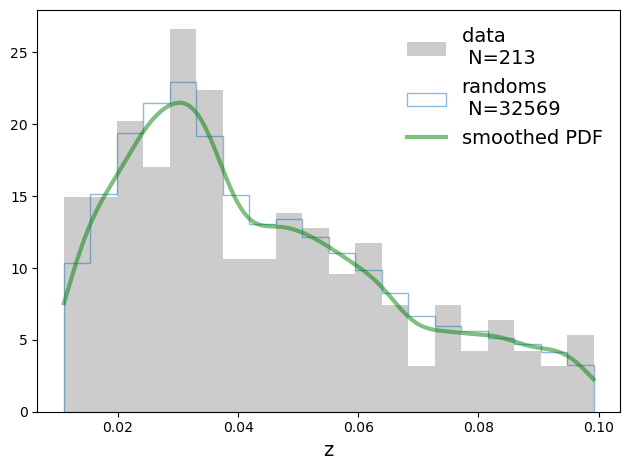

In [476]:
arand2 = rand.genrand(agnlowmass,200,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
                     data_path=data_directory,plot=True,plot_filename=None)


number of randoms: 887041


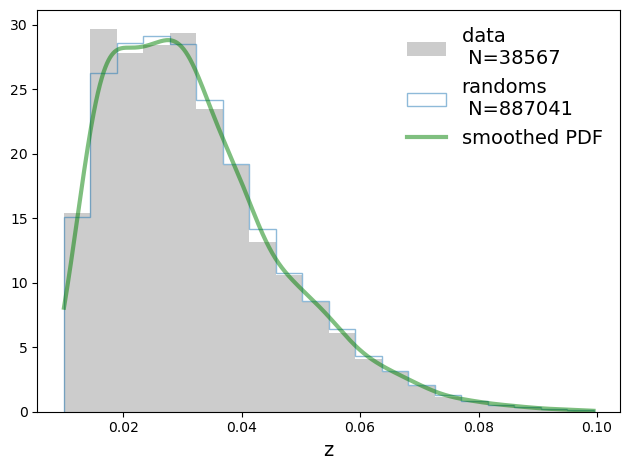

In [60]:
grandt = rand.genrand(gal,23,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=False,\
                     plot=True,plot_filename=None)

# exclude galactic plane:
gal = gal[(gal['b']<-8) | (gal['b']>8)]
grand = grandt[(grandt['b']<-8) | (grandt['b']>8)]

In [473]:
nonzero=(agn['Mbh']>0)
agnmass=agn[nonzero]

# bins for wppi/wprp
ratiobins=np.arange(0,13,1,dtype=float)
ratiobins[0]=0.01
ratiopibins=np.arange(1,13,1)

pimax=40

# Different pibins
pibins = np.logspace(0,np.log10(40),6, dtype=int)
linpibins = np.arange(1,41,1)
pibinsmod = np.logspace(0,np.log10(40),3, dtype=int)
pibinsmod[0]=2
pibinsmod[1]=10

# Different rp bins
binsmod = np.logspace(0,np.log10(40),6,dtype=int)
binsmod = binsmod.astype(dtype=float)
binsmod = np.insert(binsmod, 0, 0.1)
binsmod = np.delete(binsmod,1)
binsmod = np.delete(binsmod,2)
binsmod[2]=10.0

linbins = np.arange(0,41,1, dtype=float)
linbins[0] = 0.01

nbins = 10
bins = np.logspace(-1, np.log10(40), nbins + 1)


# z space bins
zbins=np.arange(0.01,.11,.01)


stmin=np.min(agnmass['z'])
stmax=np.max(agnmass['z'])
increm=(0.100001-stmin)/8
zbinsmod=np.arange(stmin,stmax+increm,increm)

# stellar mass bin
stmin=np.min(agnmass['log_Ms'][agnmass['log_Ms']>=8])
stmax=np.max(agnmass['log_Ms'][agnmass['log_Ms']>=8])
increm=(stmax-stmin)/5
msbinsmod=np.arange(stmin,stmax+increm,increm)

increm=(stmax-stmin)/9
msbins=np.arange(stmin,stmax+increm,increm)

stmin=np.min(agnmass['Mbh'][agnmass['Mbh']>0])
stmax=np.max(agnmass['Mbh'][agnmass['Mbh']>0])
increm=(stmax-stmin)/9
massbins=np.arange(stmin,stmax+increm,increm)

# percentage of each mass bin
percentile=33


In [438]:
# pdf=PdfPages('/home/almhatre/data/Plots/Binned Obscuration Clustering 33 percentile.pdf')

In [474]:
%autoreload 2

agnlowmass, agnmidmass, agnhighmass = control_var(agn=agnmass,bins=zbins,control='z',var='Mbh',percentile=percentile)




In [453]:
agnlowmass2,agnmidmass2,agnhighmass2=control_mult_var(agn=agnmass,bins1=zbins,bins2=massbins,control1='z',control2='Mbh',var='L210',percentile=50)


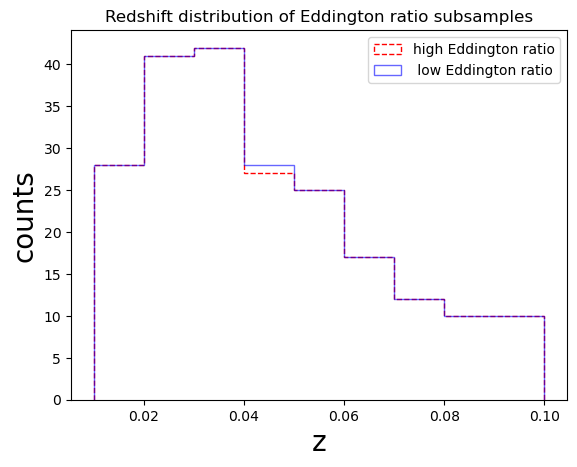

In [475]:
plt.hist(agnhighmass['z'],bins=zbins,histtype='step',label='high Eddington ratio',color='red', linestyle='--')
plt.hist(agnlowmass['z'],bins=zbins,histtype='step',label=' low Eddington ratio',color='blue',alpha=0.6)
# plt.hist(arand2['z'],bins=zbins,histtype='step',label=' random',density=True)
graph=plt.title('Redshift distribution of Eddington ratio subsamples')
plt.xlabel('z',fontsize=20)
plt.ylabel('counts',fontsize=20)
plt.legend()

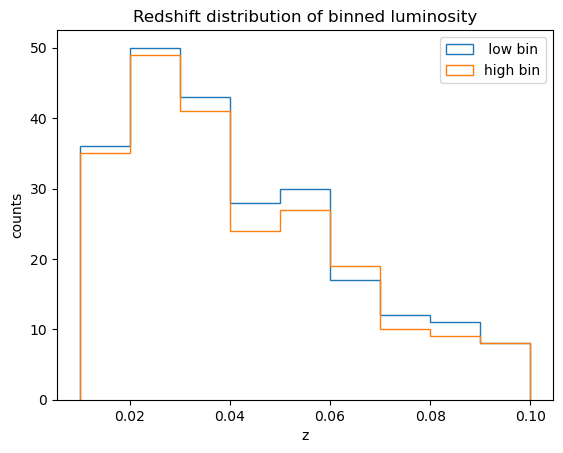

In [358]:
plt.hist(agnlowmass2['z'],bins=zbins,histtype='step',label=' low bin')
plt.hist(agnhighmass2['z'],bins=zbins,histtype='step',label='high bin')
# plt.hist(arand2['z'],bins=zbins,histtype='step',label=' random',density=True)
graph=plt.title('Redshift distribution of binned luminosity')
plt.xlabel('z')
plt.ylabel('counts')
plt.legend()


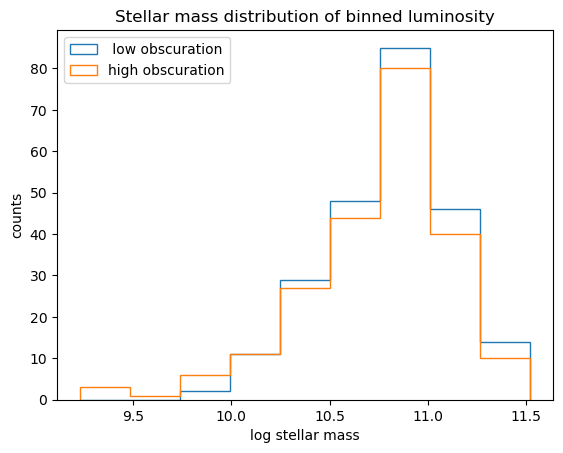

In [359]:
plt.hist(agnlowmass2['log_Ms'],bins=msbins,histtype='step',label=' low obscuration')
plt.hist(agnhighmass2['log_Ms'],bins=msbins,histtype='step',label='high obscuration')
# plt.hist(agn['z'],bins=zbins,histtype='step',label='total')
graph=plt.title('Stellar mass distribution of binned luminosity')
plt.xlabel('log stellar mass')
plt.ylabel('counts')
plt.legend()


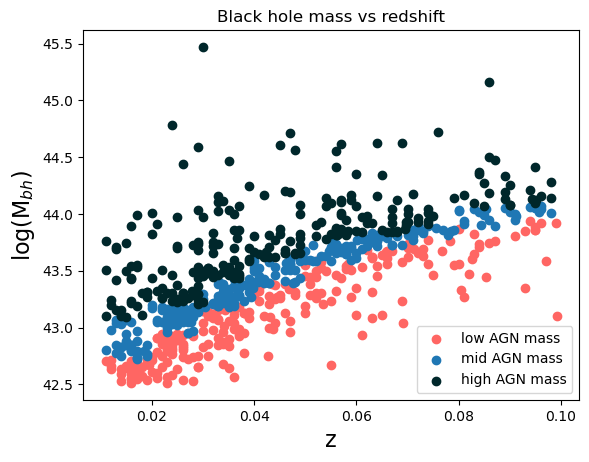

In [469]:

plt.scatter(agnlowmass['z'],agnlowmass['L210'],label='low AGN mass',color='#FF6663')
plt.scatter(agnmidmass['z'],agnmidmass['L210'],label="mid AGN mass")
plt.scatter(agnhighmass['z'],agnhighmass['L210'],label='high AGN mass',color='#00272B')
plt.xlabel('z',fontsize=16)
plt.ylabel('log(M$_{bh}$)',fontsize=16)
# plt.ylabel('Black hole mass',fontsize=16)
plt.title('Black hole mass vs redshift')
plt.legend()


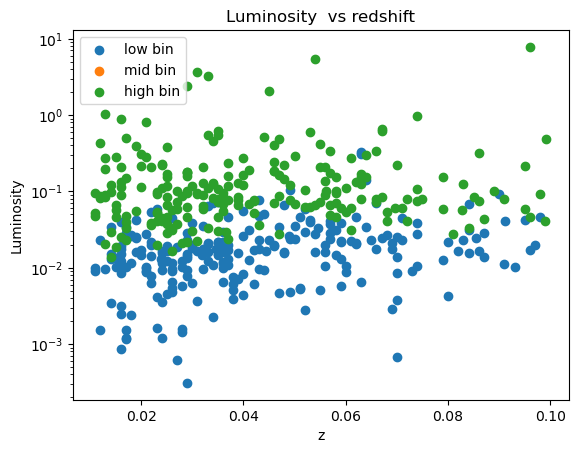

In [328]:

plt.scatter(agnlowmass2['z'],agnlowmass2['Edd_rat'],label='low bin')
plt.scatter(agnmidmass2['z'],agnmidmass2['Edd_rat'],label="mid bin")
plt.scatter(agnhighmass2['z'],agnhighmass2['Edd_rat'],label='high bin')
plt.xlabel('z')
plt.ylabel('Luminosity')
plt.title('Luminosity  vs redshift')
plt.legend()
plt.yscale('log')

In [472]:
rp_high,wp_agp_high,wp_agp_err_high,Mag_high = w.cross_wp(d1=agnhighmass, d2=gal, r1=arand2, r2=grand, bins=bins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.053 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.061 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.015 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.746 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.319 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

In [462]:
rp_high2,wp_agp_high2,wp_agp_err_high2,Mag_high2 = w.cross_wp(d1=agnhighmass2, d2=gal, r1=arand2, r2=grand, bins=bins, pimax=pimax, m=5, estimator='L')


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.042 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

In [463]:
rp_low,wp_agp_low,wp_agp_err_low,Mag_low=w.cross_wp(d1=agnlowmass, d2=gal, r1=arand2, r2=grand, bins=bins, pimax=pimax, m=5, estimator='L')


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%...100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

In [464]:
rp_low2,wp_agp_low2,wp_agp_err_low2,Mag_low2=w.cross_wp(d1=agnlowmass2, d2=gal, r1=arand2, r2=grand, bins=bins, pimax=pimax, m=5, estimator='L')


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.042 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

Text(0.5, -0.08, 'chi square: ~19 over 10 degress of freedom')

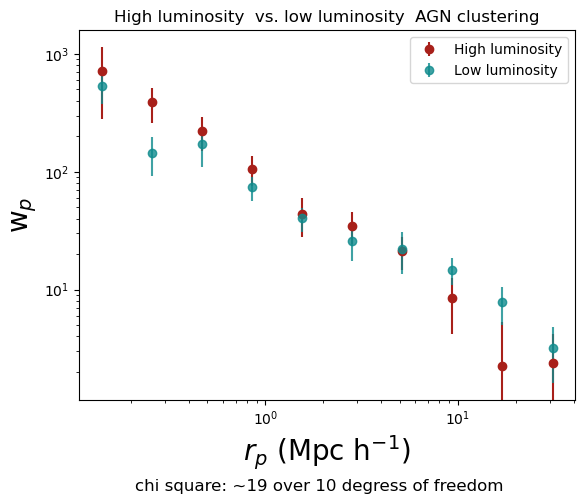

In [470]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp_high,wp_agp_high,yerr=wp_agp_err_high,fmt='o',label='High luminosity',color='#A8201A')
plt.errorbar(rp_low,wp_agp_low,yerr=wp_agp_err_low,fmt='o',label='Low luminosity',color='#0F8B8D',alpha=0.8)
plt.xlabel('$r_{p}$ (Mpc h$^{-1}$)',fontsize=20)
plt.ylabel('w$_{p}$',fontsize=20)
plt.title('High luminosity  vs. low luminosity  AGN clustering')
plt.legend()

chi = wp_chi_squared(wp_agp_high,wp_agp_low,Mag_high,Mag_low)
plt.figtext(0.5, -.08, 'chi square: ~'+str(int(chi))+ ' over '+ '10 degress of freedom', ha="center", fontsize=12)

Text(0.5, -0.08, 'chi square: ~8 over 10 degress of freedom')

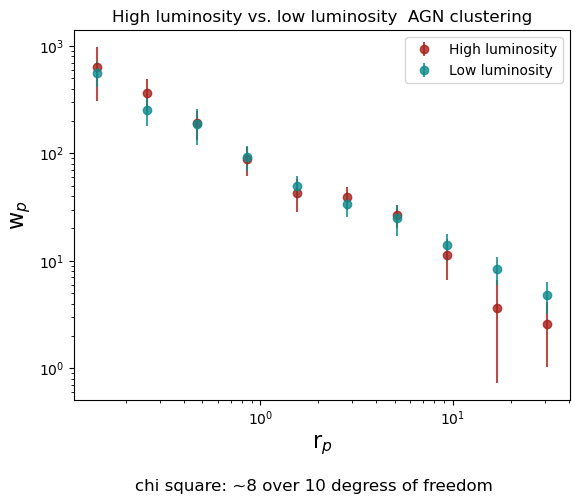

In [471]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp_high2,wp_agp_high2,yerr=wp_agp_err_high2,fmt='o',label='High luminosity',color='#A8201A',alpha=0.8)
plt.errorbar(rp_low2,wp_agp_low2,yerr=wp_agp_err_low2,fmt='o',label='Low luminosity',color='#0F8B8D',alpha=0.8)
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('High luminosity vs. low luminosity  AGN clustering')
plt.legend()

chi2 = wp_chi_squared(wp_agp_high2,wp_agp_low2,Mag_high2,Mag_low2)
plt.figtext(0.5, -.08, 'chi square: ~'+str(int(chi2))+ ' over '+ '10 degress of freedom', ha="center", fontsize=12)

In [171]:
%autoreload 2
pi_low,pi_p_low,pi_p_err_low,Mag_pilow=wz.cross_wppi(d1=agnlowmass, d2=gal, r1=arand2, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='L')
# pi_low2,pi_p_low2,pi_p_err_low2,Mag_pilow2=wz.cross_wppi(d1=agnlowmass2, d2=gal, r1=arand2, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.068 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.064 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.059 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.064 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.064 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.065 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

In [172]:
pi_high,pi_p_high,pi_p_err_high,Mag_pihigh=wz.cross_wppi(d1=agnhighmass, d2=gal, r1=arand2, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='L')
# pi_high2,pi_p_high2,pi_p_err_high2,Mag_pihigh2=wz.cross_wppi(d1=agnhighmass2, d2=gal, r1=arand2, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.059 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.042 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.042 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%...100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.042 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.058 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%......

Text(0.5, -0.1, 'chi squared: 5.530066002316014 / 6')

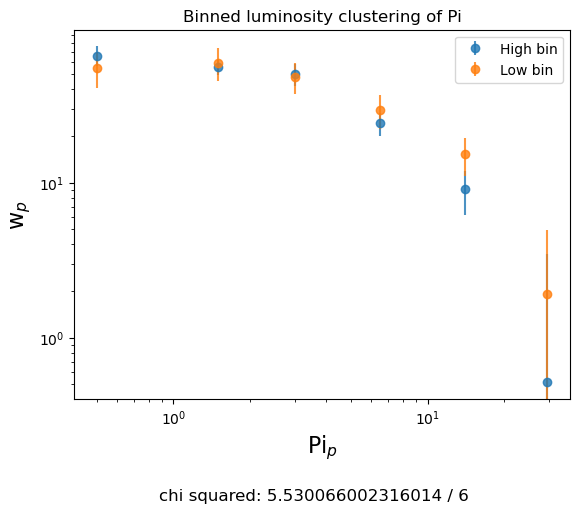

In [477]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(pi_high,pi_p_high,yerr=pi_p_err_high,fmt='o',label='High bin',alpha=0.8)
plt.errorbar(pi_low,pi_p_low,yerr=pi_p_err_low,fmt='o',label='Low bin',alpha=0.8)
plt.xlabel('Pi$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Binned luminosity clustering of Pi')
plt.legend()

chi3 = wp_chi_squared(pi_p_high,pi_p_low,Mag_pihigh,Mag_pilow)
plt.figtext(0.5, -.1, 'chi squared: '+str(chi3)+ ' / '+ '6', ha="center", fontsize=12)

Text(0.5, -0.1, 'chi squared: 4.851832006291857 / 6')

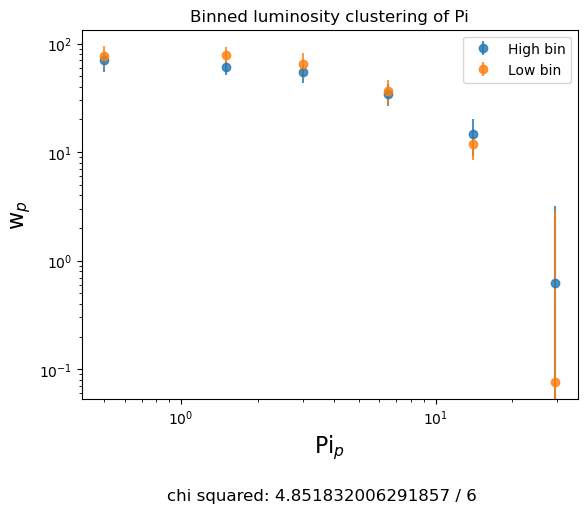

In [174]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(pi_high2,pi_p_high2,yerr=pi_p_err_high2,fmt='o',label='High bin',alpha=0.8)
plt.errorbar(pi_low2,pi_p_low2,yerr=pi_p_err_low2,fmt='o',label='Low bin',alpha=0.8)
plt.xlabel('Pi$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Binned luminosity clustering of Pi')
plt.legend()

chi4 = wp_chi_squared(pi_p_high2,pi_p_low2,Mag_pihigh2,Mag_pilow2)
plt.figtext(0.5, -.1, 'chi squared: '+str(chi4)+ ' / '+ '6', ha="center", fontsize=12)

In [19]:
rp_high_mod,wp_agp_high_mod,wp_agp_err_high_mod,Mag = w.cross_wp(d1=agnhighmass, d2=gal, r1=arand, r2=grand, bins=binsmod, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.065 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.029 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.100% done. Time taken =  0.006 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%....100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%...100% done. Time taken =  0.032 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs


In [20]:
rp_low_mod,wp_agp_low_mod,wp_agp_err_low_mod,Mag=w.cross_wp(d1=agnlowmass, d2=gal, r1=arand, r2=grand, bins=binsmod, pimax=pimax, m=5, estimator='P')


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.076 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs


In [21]:
ratio_p_err_high=ratio_error(pi_p_high,wp_agp_high_mod,pi_p_err_high,wp_agp_err_high_mod)
ratio_p_err_low=ratio_error(pi_p_low,wp_agp_low_mod,pi_p_err_low,wp_agp_err_low_mod)

Text(0.5, 1.0, 'Ratio of Wp(pi)/Wp(rp) 50 percentiles: 6 log bins of rp/pi, pimax=40')

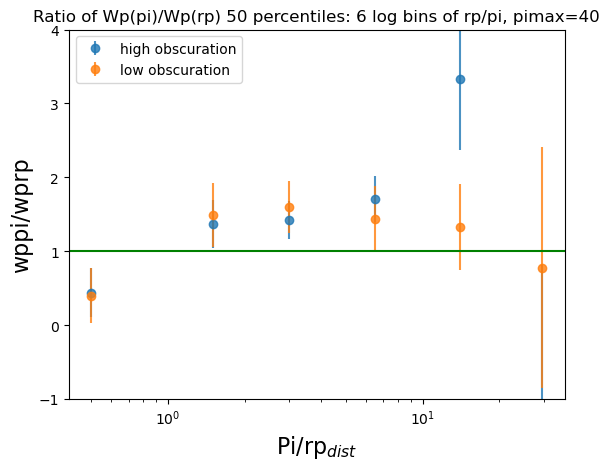

In [23]:
plt.xscale("log")
plt.errorbar(pi_high, pi_p_high/wp_agp_high_mod,yerr=ratio_p_err_high,fmt='o',label='high obscuration',alpha=0.8)
plt.errorbar(pi_low, pi_p_low/wp_agp_low_mod,yerr=ratio_p_err_low,fmt='o',label='low obscuration',alpha=0.8)
plt.axhline(1,color='g')
plt.ylim([-1,4])
plt.legend()
plt.xlabel('Pi/rp$_{dist}$',fontsize=16)
plt.ylabel('wppi/wprp',fontsize=16)
plt.title('Ratio of Wp(pi)/Wp(rp) 50 percentiles: 6 log bins of rp/pi, pimax=40')